[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



 Training model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.102200
20,1.108400
30,1.096400
40,1.084800
50,1.063800
60,1.052200
70,1.021400
80,0.975200
90,0.922000
100,0.869100



 Model: bert-base-uncased
 Accuracy: 0.7555
 F1 Score: 0.7552

 Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76      1001
     neutral       0.73      0.71      0.72      1430
    positive       0.79      0.81      0.80      1103

    accuracy                           0.76      3534
   macro avg       0.76      0.76      0.76      3534
weighted avg       0.75      0.76      0.76      3534


 Training model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.095900
20,1.093500
30,1.091600
40,1.084500
50,1.086000
60,1.083600
70,1.074400
80,1.016200
90,0.881300
100,0.790800



 Model: roberta-base
 Accuracy: 0.7612
 F1 Score: 0.7599

 Classification Report:

              precision    recall  f1-score   support

    negative       0.75      0.76      0.75      1001
     neutral       0.76      0.69      0.72      1430
    positive       0.78      0.85      0.81      1103

    accuracy                           0.76      3534
   macro avg       0.76      0.77      0.76      3534
weighted avg       0.76      0.76      0.76      3534


 Training model: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.097300
20,1.097800
30,1.096500
40,1.088000
50,1.084400
60,1.081500
70,1.070700
80,1.038000
90,0.995500
100,0.899800



 Model: microsoft/deberta-v3-base
 Accuracy: 0.7748
 F1 Score: 0.7737

 Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.78      0.77      1001
     neutral       0.77      0.71      0.74      1430
    positive       0.80      0.85      0.82      1103

    accuracy                           0.77      3534
   macro avg       0.77      0.78      0.78      3534
weighted avg       0.77      0.77      0.77      3534



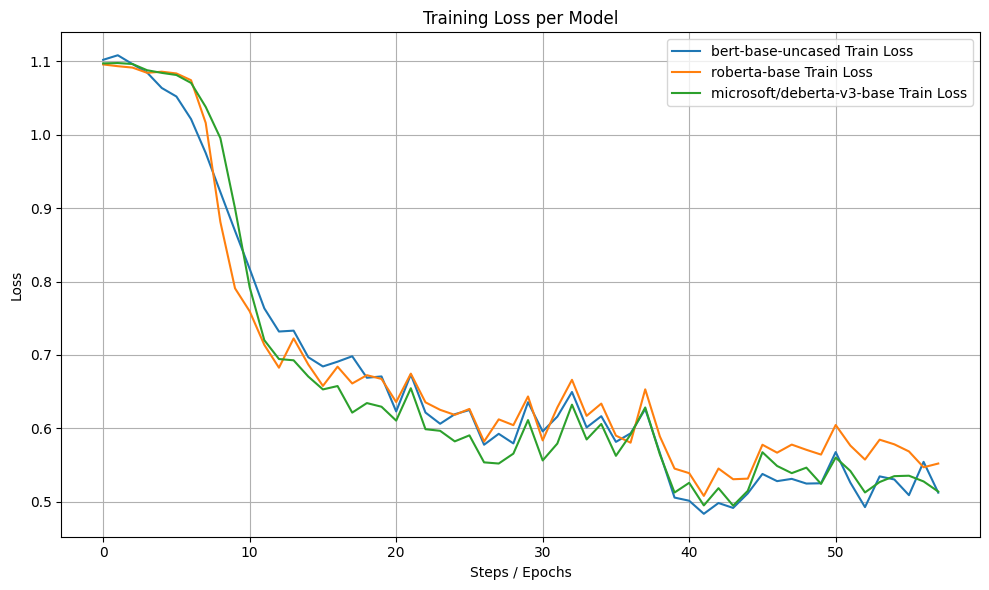


 Final Results:
                       model  accuracy        f1
2  microsoft/deberta-v3-base  0.774759  0.773711
1               roberta-base  0.761177  0.759883
0          bert-base-uncased  0.755518  0.755160


In [2]:
import os
import pandas as pd
import re
import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

#  清理 working 目录释放空间
working_path = '/kaggle/working'
for root, dirs, files in os.walk(working_path):
    for file in files:
        try:
            os.remove(os.path.join(root, file))
        except:
            pass

#  下载 NLTK 资源
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ========== 步骤 1：清洗函数 ==========
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text).lower().strip()
    text = re.sub(r"\s+", " ", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) >= 3]
    return " ".join(tokens)

# ========== 步骤 2：加载并清洗数据 ==========
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
train_df, validation_df = train_test_split(train_df, test_size=0.1, random_state=42)

for df in [train_df, validation_df, test_df]:
    df['text'] = df['text'].fillna('').astype(str)
    df['text'] = df['text'].apply(clean_text)

# ========== 步骤 3：标签映射 ==========
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
for df in [train_df, validation_df, test_df]:
    df['sentiment'] = df['sentiment'].map(sentiment_map)

# ========== 步骤 4：Dataset 类 ==========
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# ========== 步骤 5：训练参数 ==========
training_args = TrainingArguments(
    output_dir='/kaggle/working/tmp',
    overwrite_output_dir=True,
    save_strategy='no',
    logging_strategy='steps',
    logging_steps=10,
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to=[]
)

# ========== 步骤 6：训练多个模型并画图 ==========
model_names = ['bert-base-uncased', 'roberta-base', 'microsoft/deberta-v3-base']
results = []

plt.figure(figsize=(10, 6))  # 初始化图表

for model_name in model_names:
    print(f"\n========================")
    print(f" Training model: {model_name}")
    print(f"========================")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    def tokenize(df):
        return tokenizer(
            df['text'].tolist(),
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

    train_encodings = tokenize(train_df)
    validation_encodings = tokenize(validation_df)
    test_encodings = tokenize(test_df)

    train_dataset = SentimentDataset(train_encodings, train_df['sentiment'].tolist())
    validation_dataset = SentimentDataset(validation_encodings, validation_df['sentiment'].tolist())
    test_dataset = SentimentDataset(test_encodings, test_df['sentiment'].tolist())

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset
    )

    trainer.train()

    #  收集 loss 日志用于绘图
    log_history = trainer.state.log_history
    train_loss = [log['loss'] for log in log_history if 'loss' in log]
    plt.plot(train_loss, label=f'{model_name} Train Loss')
   

    #  模型评估
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')

    results.append({'model': model_name, 'accuracy': accuracy, 'f1': f1})

    print(f"\n Model: {model_name}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f"\n Classification Report:\n")
    print(classification_report(labels, preds, target_names=['negative', 'neutral', 'positive']))

    # 保存预测
    test_df['predicted'] = preds
    test_df.to_csv(f"/kaggle/working/{model_name.replace('/', '_')}_preds.csv", index=False)

#  最终绘制并保存 loss 曲线图
plt.title("Training Loss per Model")
plt.xlabel("Steps / Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/loss_comparison.png")
plt.show()

#  输出最终结果对比表
df_results = pd.DataFrame(results).sort_values(by='f1', ascending=False)
print("\n Final Results:")
print(df_results)
